# The HFM library - A fast marching solver with adaptive stencils

## Part : Algorithmic enhancements to the fast marching method
## Chapter : Comparison with geodesic shooting

In this chapter, we illustrate the computation of geodesics using Hamilton's equations, and compare them to those extracted with the fast marching methods.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Isotropic metrics and the Brachistochrone problem](#1.-Isotropic-metrics-and-the-Brachistochrone-problem)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('HamiltonianShooting','FMM'))

In [2]:
from agd import HFMUtils
from agd import LinearParallel as lp
from agd import Metrics
from agd import AutomaticDifferentiation as ad
from agd import FiniteDifferences as fd
from agd.Plotting import savefig; #savefig.dirName = 'Images/HamiltonianShooting'
from agd import Interpolation

norm_infinity = ad.Optimization.norm_infinity
lo = ad.left_operand
Interp = Interpolation.UniformGridInterpolation

In [3]:
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt

In [4]:
def reload_packages():
    from Miscellaneous.rreload import rreload
    global ad,lp,fd,Metrics,Interpolation
    ad,lp,fd,Metrics,Interpolation = rreload([ad,lp,fd,Metrics,Interpolation],rootdir="../..")

## 1. Isotropic metrics and the Brachistochrone problem

A brachistochrone curve, in mathematics and physics, is a curve of fastest descent, between two points in a uniform gravity field, and neglecting friction. The standard brachistochrone problem assumes that the curve can be constructed  without constraints in free space and admits an explicit solution: the cycloid. See [Wikipedia](https://en.wikipedia.org/wiki/Brachistochrone_curve).

In this section, we recover this explicit solution numerically.
Consider a point of mass $m$, at altitude $h$, with velocity $v$, and denote by $g$ the intensity of the gravity field. The total energy (kinetic + potential) of this point is 
$$
    E = m g h + \frac 1 2 m \|v\|^2,
$$
and it is conserved along the motion, provided there is no friction.

For simplicity, but without loss of generality, we assume that $m = 1$ and $g=1$, and denote $z = -h$. Up to a vertical translation, we may also assume that the conserved energy equals zero. Then we obtain $-z+\frac 1 2 \|v\|^2=0$, equivalently
$$
    \frac {\|v\|^2}{2 z} = 1.
$$
Thus the brachistochrone problem amounts to find a geodesic, between two given points, for an isotropic metric whose (half squared) expression is given above. More explicitly, denoting by $q=(x,z)$ the position, and $v$ the speed
$$
    F_q(v) := \frac {\|v\|}{\sqrt z}.
$$
The matrix form, the Riemannian metric at $q=(x,z) \in R \times R_{++}$ reads
$$
    M(q) = M(x,z) = \frac {\mathrm{Id}} z.
$$

**A closely related model.** The Poincare model of the hyperbolic plane is posed on the same domain $R\times R_{+++}$ and involves the metric $M(x,z) = \mathrm{Id} / {z^2}$ (note the square in the denominator). One significant difference is that the Poincare model is geodesically complete, whereas the Brachistochrone model isn't (geodesics reach the boundary $R \times \{0\}$ in finite time).
The Poincare half plane model naturally arises in the context of [Fisher-Rao metrics](FisherRao.ipynb).

### 1.1 Explicit solution: the cycloid.
An explicit geodesic is known for the brachistochrone metric, known as the cycloid, see [Wikipedia](https://en.wikipedia.org/wiki/Brachistochrone_curve), and reading
$$
    (x(t),z(t)) = (t-\sin t, 1-\cos t),
$$
for $t \in ]0,2 \pi[$.
All other geodesics are dilations and horizontal translations of this particular solution $\gamma(t)=(x(t),z(t))$
$$
    \lambda \gamma(t/\lambda) + (x_0,0),
$$
where $\lambda>0$ and $x_0 \in R$.

In [5]:
def Cycloid(t): return ad.array((t-np.sin(t),1.-np.cos(t)))

Note : recall that the vertical axis is reversed, a.k.a. $z=-h$, w.r.t the physical brachistochrone problem.

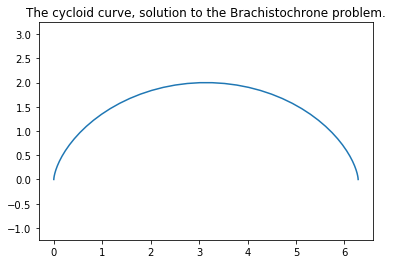

In [6]:
plt.title('The cycloid curve, solution to the Brachistochrone problem.')
plt.axis('equal')
T = np.linspace(0,2*np.pi)
plt.plot(*Cycloid(T));

We introduce a slightly reduced interior interval, since the Brachistochrone problem becomes singular when the object velocity vanishes.

In [7]:
Tint = np.linspace(0.2,2*np.pi-0.4) #Interior interval

Let us emphasize that the Cycloid is not parametrized at constant velocity:
$$
    x(t) = \frac{t^3} 6+ O(t^5), \quad z(t) = \frac {t^2} 2 + O(t^4)
$$
Hence the endpoints of the Cycloid on this interval are extremely close to the singularity of the metric at $z=0$.
This raises a substantial difficulty for fast marching and shooting methods.

In [8]:
Cycloid(Tint[0])

array([0.00133067, 0.01993342])

### 1.2 Solution using the fast marching method

In [9]:
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'arrayOrdering':'RowMajor',
    'seeds': [Cycloid(0.2)],
    'tips': [Cycloid(2.*np.pi-0.2)]
})
dx = 0.4 # Use a slightly larger domain, containing the trajectory in its interior
hfmIn.SetRect([[-dx,2.*np.pi+dx],[0,2+dx]],dimx=300)
X,Z = hfmIn.Grid()

In [10]:
hfmIn['cost'] = Metrics.Isotropic(1/np.sqrt(Z))

In [11]:
hfmOut = hfmIn.RunSmart()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.007095 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


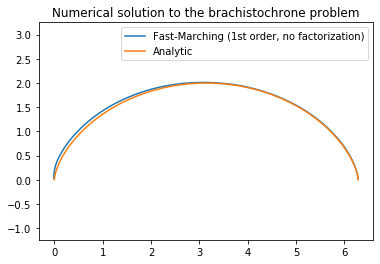

In [12]:
plt.title("Numerical solution to the brachistochrone problem") 
plt.plot(*hfmOut['geodesics'][0],label="Fast-Marching (1st order, no factorization)")
plt.plot(*Cycloid(T),label="Analytic")
plt.axis('equal'); plt.legend();

In [13]:
hfmIn2 = hfmIn.copy()
hfmIn2.update({
    # Improve accuracy
    'order':2,
    'factoringRadius':20,
    
    # Export relevant data
    'exportGeodesicFlow':True,
    'exportValues':True,
})

Introducing source factorization and a higher order method yields a more accurate trajectory.

In [14]:
hfmOut = hfmIn2.RunSmart()

Field verbosity defaults to 1
Field seedRadius defaults to 2
Fast marching solver completed in 0.010622 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


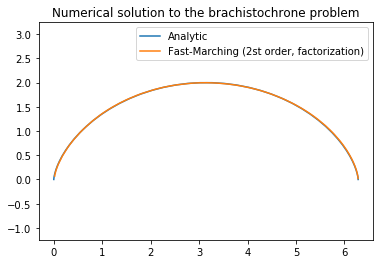

In [15]:
plt.title("Numerical solution to the brachistochrone problem") 
plt.plot(*Cycloid(T),label="Analytic")
plt.plot(*hfmOut['geodesics'][0],label="Fast-Marching (2st order, factorization)")
plt.axis('equal'); plt.legend();

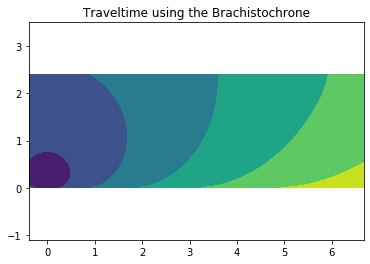

In [16]:
plt.title('Traveltime using the Brachistochrone')
plt.contourf(X,Z,hfmOut['values'])
plt.axis('equal');

### 1.3 Geodesic shooting

Recall that the Hamiltonian is defined as the half square dual metric. For the brachistochrone, it reads
$$
    H(q,p) := \frac z 2 \|p\|^2,
$$
where $q=(x,z)$ is the position, and $p$ is the momentum. In this simple case, the velocity and momentum at a point $q=(x,z)$ are related by the equation
$$
    v = \frac {\partial H}{\partial p} = z p.
$$

In [17]:
def Brach_A_(q,p):
    """Analytic Hamiltonian for the brachistochrone problem"""
    return lo(q[1]/2.) * (p**2).sum(axis=0)
Brach_A = Metrics.Hamiltonian(Brach_A_)

**Note on the use of `lo = ad.left_operand`.** See help of this function, or the notebook [ADBugs](../../Notebooks_Algo/ADBugs.ipynb).

In [18]:
Brach_I = Metrics.Hamiltonian(hfmIn['cost'],grid=hfmIn.Grid(),order=3)

In [19]:
Cycloid(ad.Dense.identity(constant=0.2)).gradient(0)

array([0.01993342, 0.19866933])

In [20]:
t_ad = ad.Dense.identity(constant=0.2)
Cyc_ad = Cycloid(t_ad)
q0 = Cyc_ad.value
v0 = Cyc_ad.gradient(0) # Initial velocity
p0 = v0/q0[1] # Initial impulsion

print(f"Exact hamiltonian flow: {Brach_A.flow(q0,p0)}")
print(f"Interpolated hamiltonian flow: {Brach_I.flow(q0,p0)}")

Exact hamiltonian flow: (array([0.01993342, 0.19866933]), array([ -0.        , -50.16700053]))
Interpolated hamiltonian flow: (array([0.01943866, 0.19373818]), array([ 4.65921484e-15, -5.18012345e+01]))


When using external ODE solvers, which ignore the Hamiltonian structure, one often needs a function which takes as input the concatenated position and impulsion, and returns their concatenated derivatives - the Hamiltonian flow.
This is the purpose of the `.flow_cat` member of the `Hamiltonian` class.

In [21]:
QP_A,dict_A = scipy.integrate.odeint(Brach_A.flow_cat,np.concatenate((q0,p0)),Tint,full_output=True)

The computation is a bit longer with the interpolated hamiltonian. Indeed, the `odeint` routine introduces substantial refinement, due to the lesser smoothness of the interpolated flow.

In [22]:
%%time
QP_I,dict_I = scipy.integrate.odeint(Brach_I.flow_cat,np.concatenate((q0,p0)),Tint,full_output=True)

CPU times: user 4.66 s, sys: 57.4 ms, total: 4.72 s
Wall time: 4.72 s


The ODE with an exact hamiltonian is, clearly, accurate to a very high order. In contrast, the spline interpolation introduces a slight deviation.

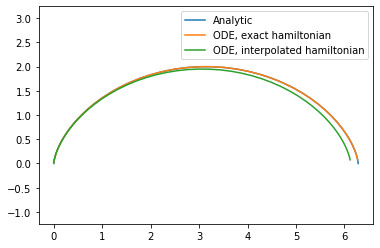

In [23]:
plt.plot(*Cycloid(T),label="Analytic")
plt.plot(*QP_A[:,:2].T,label="ODE, exact hamiltonian")
plt.plot(*QP_I[:,:2].T,label="ODE, interpolated hamiltonian")
plt.axis('equal'); plt.legend();

The Hamiltonian class provides some ODE integration schemes, in particular semi-implicit symplectic schemes. They do take into account the *Hamiltonian* structure, and may therefore offer an interesting alternative to `odeint` in some cases.

In [24]:
%%time
Ttot = Tint[-1]-Tint[0]
# Semi-implicit Euler (symplectic, first order scheme)
Q_Ep,_,_ = Brach_I.integrate(q0,p0,scheme='Euler-p',T=Ttot,niter=3*len(Tint),path=True)

CPU times: user 4.98 s, sys: 52.4 ms, total: 5.03 s
Wall time: 4.99 s


In [25]:
%%time
# Semi-implicit Verlet (symplectic, second order scheme)
Q_Vp,_,_ = Brach_I.integrate(q0,p0,scheme='Verlet-p',T=Ttot,niter=3*len(Tint),path=True)

CPU times: user 5.99 s, sys: 114 ms, total: 6.1 s
Wall time: 6.02 s


In [26]:
%%time
# Runge-Kutta (non-symplectic, fourth order scheme)
Q_RK4,_,_ = Brach_I.integrate(q0,p0,scheme='Runge-Kutta-4',T=Ttot,niter=3*len(Tint),path=True)

CPU times: user 3.48 s, sys: 60.2 ms, total: 3.54 s
Wall time: 3.5 s


Here, the Verlet scheme seems to be the most accurate.

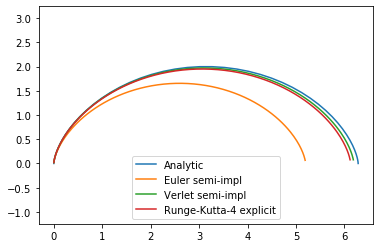

In [27]:
plt.plot(*Cycloid(T),label="Analytic")
plt.plot(*Q_Ep,label="Euler semi-impl")
plt.plot(*Q_Vp,label="Verlet semi-impl")
plt.plot(*Q_RK4,label="Runge-Kutta-4 explicit")

plt.axis('equal'); plt.legend();

### 1.4 Initial momentum from the PDE solution

The (half-)squared riemannian distance from a seed point $q_*$ is smooth is defined as 
$$
    U(q) := \frac 1 2 d_M(q_*,q)^2.
$$
It is a smooth function - locally around $q_*$ - if the metric is Riemannian and smooth, and therefore it is a good candidate for interpolation.

In [123]:
def energy_impulsion_i(hfmIn,hfmOut,**kwargs):
    """Returns the energy x -> u(x)^2/2, and its euclidean gradient referred to as the impulsion, interpolated."""
    grid = hfmIn.Grid()
    values = hfmOut['values']
    
    energy_i = Interp(grid,0.5*values**2,**kwargs)
    
    def impulsion_i(q):
        q_ad = ad.Dense.identity(constant=q,shape_free=q.shape[:1])
        return energy_i(q_ad).gradient()
    
    return energy_i,impulsion_i

In [29]:
energy_i,impulsion_i = energy_impulsion_i(hfmIn2,hfmOut,order=3)

Solving Hamilton's geodesic equations on the interval $[0,1]$, with terminal condition
$$
    p_1 = \nabla U(q_1),
$$
at time $t=1$, where $q_1\in \Omega$ is arbitrary, leads back to the seed $q_*$. 
Riemannian metrics are symmetric, we can solve forward in time, only reversing the momentum. 
In other words letting $q_0 \in \Omega$ be arbitrary, and $p_0 := \nabla U(q0)$ leads at time $1$ to the seed.

**Limitation.** This approach only works if the Riemannian geodesic between the seed and tip remains in the computational domain interior at all times, and does not meet any obstacles.

In [30]:
q0 = np.array([3.,1.])
p0 = -impulsion_i(q0)
QP = scipy.integrate.odeint(Brach_A.flow_cat,np.concatenate((q0,p0)),np.linspace(0,1.))

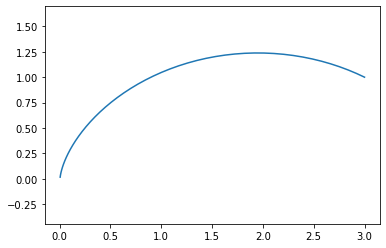

In [31]:
plt.plot(*QP[:,:2].T)
plt.axis('equal');

If the vector dimension `vdim` of the hamiltonian is correctly set, then one can integrate multiple geodesics simultaneously.

In [32]:
Brach_A.vdim=2 # Fix vector space dimension. (Used internally for reshaping purposes.)

np.random.seed(42); nSamples = 10
q0 = np.array([np.random.uniform(0.,2.*np.pi,nSamples),np.random.uniform(0.2,2,nSamples)])
p0 = -impulsion_i(q0)
T = np.linspace(0,1)

#Flatten position and impulsion, as required by odeint
QP = scipy.integrate.odeint(Brach_A.flow_cat,np.concatenate((q0,p0),axis=0).flatten(),T)
#Expand back the solution
Q = QP[:,:2*nSamples].reshape((len(T),2,nSamples))
P = QP[:,2*nSamples:].reshape((len(T),2,nSamples))

In [33]:
hfmIn['origin']

array([-0.4      , -0.0041415])

In [34]:
hfmIn

{'model': 'Isotropic2',
 'arrayOrdering': 'RowMajor',
 'seeds': [array([0.00133067, 0.01993342])],
 'tips': [array([6.28185464, 0.01993342])],
 'gridScale': 0.023610617690598624,
 'dims': array([300., 102.]),
 'origin': array([-0.4      , -0.0041415]),
 'cost': <agd.Metrics.isotropic.Isotropic at 0x11d9b6880>}

In [35]:
domain_patch = plt.Rectangle(hfmIn['origin'],*(hfmIn['dims']*hfmIn['gridScale']),
                            linewidth=1,edgecolor='b',facecolor='none')
seed_patch = plt.Circle(np.array(hfmIn['seeds'][0]).T,3*hfmIn['gridScale'])

In [36]:
def add_patches(hfmIn):
    """Draws a bounding rectangle, and scatters the seeds"""
    plt.gca().add_patch(plt.Rectangle(hfmIn['origin'],*(hfmIn['dims']*hfmIn['gridScale']),
                                      linewidth=1,edgecolor='black',facecolor='none'))
    plt.gca().add_patch(plt.Circle(np.array(hfmIn['seeds']).T,3*hfmIn['gridScale']))

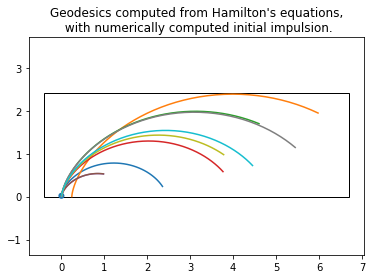

In [37]:
plt.title("Geodesics computed from Hamilton's equations,\n with numerically computed initial impulsion.")
plt.axis('equal'); add_patches(hfmIn)
for i in range(nSamples):
    plt.plot(*Q[:,:,i].T)

Note that one of the geodesics displayed above does *not* correctly reach the seed point. Indeed, that the exact geodesic reaching this tip for this model goes outside of the computational domain. Therefore the numerical geodesic is perturbed by the presence of the domain boundary, which acts as an obstacle. 

### 1.5 The geodesic flow

Let us mention that the geodesic computation in the HFM library does not rely on Hamilton's equations of geodesics, but on integrating the upwind geodesic flow, which is much more robust in the presence of obstacles. 
More precisely, the geodesic $\gamma$ from a seed $q_*$ to a given tip $q$ obeys the ordinary differential equation
$$
    \gamma'(t) = V(\gamma(t)), 
$$
with $\gamma : [0,T] \to \Omega$ where $T = d(q_*,q)$ is the geodesic distance from the seed to the tip, and terminal condition $\gamma(T) = q$. We denoted by $V$ the geodesic flow, gradient of the distance *w.r.t the metric*. In the Riemannian case
$$
    V(q) = M(q)^{-1} \nabla u(q),
$$
where $\nabla$ denotes the usual euclidean gradient.
We illustrate below a such an approach for geodesic computation. 

**Note on regularity.**
The geodesic flow has a singularity at the origin. However, the flow times the distance to the seed point is smooth, locally around the seed point and provided the metric is Riemannian and smooth, and is therefore a good candidate for interpolation. Indeed, it is the gradient of the energy w.r.t. the metric.

**Note on the HFM implementation.**
The implementations of geodesic computation presented below and in the HFM library are related but also have significant differences. The HFM implementation uses a lower order interpolation of the flow, and has mechanisms designed to improve robustness in the presence of obstacles, for problems whose distance maps are discontinuous, etc. It also has different stopping criteria,

In [38]:
def value_flow_i(hfmIn,hfmOut):
    """Returns the distance to the seed, and the upwind geodesic flow, interpolated."""
    grid = hfmIn.Grid()
    value = hfmOut['values']
    flow = hfmOut['flow']
    
    flowXvalue_i  = Interp(grid, flow*value,order=3)
    valueXvalue_i = Interp(grid,value*value,order=3)
    
    def value_i(q): return np.sqrt(np.maximum(0.,valueXvalue_i(q)))
    def  flow_i(q,t=None,mult=1): return mult*flowXvalue_i(q)/value_i(q)
    
    return value_i,flow_i

In [39]:
value_i,flow_i = value_flow_i(hfmIn2,hfmOut)

In [40]:
q0 = [3.,1.]
T = np.linspace(0,value_i(q0))
Q = scipy.integrate.odeint(flow_i,q0,T,args=(-1,))

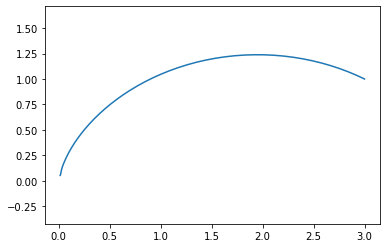

In [41]:
plt.plot(*Q.T)
plt.axis('equal');

It is often more convenient to compute several geodesics simulatenously. In Python, and using tensor based programming, this may also be more computationally efficient. However, one needs for that purpose some flattening and reshaping utilities, given the constraints of the `scipy.intergrate.odeint` routine.

In [42]:
def reshape_input_flatten_output(f,vdim):
    return lambda q,*args,**kwargs : f(q.reshape((vdim,q.size//vdim)),*args,**kwargs).flatten()

In [43]:
flow_r = reshape_input_flatten_output(flow_i,2) # Flow reshaped

In [44]:
np.random.seed(42); nSamples = 10
q0 = np.array([np.random.uniform(0.,2.*np.pi,nSamples),np.random.uniform(0.2,2,nSamples)])
T = np.linspace(0,1)
Q = scipy.integrate.odeint(flow_r,q0.flatten(),T,args=(-value_i(q0),))

All the computed geodesics end at the desired endpoint, including the one perturbed by the presence of the domain boundary. This is contrast with the approach based on geodesic shooting using Hamilton's equations of motion, which fails in such cases, see the previous subsection.

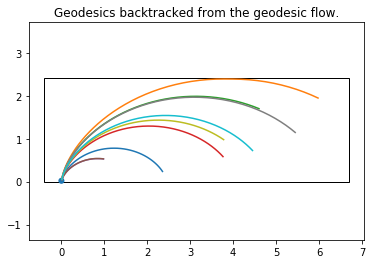

In [45]:
plt.title("Geodesics backtracked from the geodesic flow.")
plt.axis('equal'); add_patches(hfmIn)
for i in range(nSamples):
    plt.plot(Q[:,i],Q[:,i+nSamples])

## 2. Riemannian metrics, and the fastest slide on a landscape

We consider a variant of the Brachistochrone problem, where the purpose is to build the fastest slide between two given points *on a given landscape* (two dimensional). Again, we neglect friction.

The total energy of a point of mass $m$, at height $h$, velocity $\mathbf{v}$, in a gravitational field g, as before
$$
    E = m g h + \frac 1 2 m \|\mathbf{v}\|^2
$$
The total energy is conserved along the trajectory (no friction assumption), and the object velocity is therefore determined by its height. Denoting by $\mathbf{z}$ the vertical coordinate, possibly shifted, inverted and rescaled w.r.t. the height $h$, one finds that
$$
    \frac{\|\mathbf{v}\|^2}{\mathbf{z}}
$$
is constant and positive along the trajectory. In particular, positions for which $z\leq 0$ are not accessible. (These positions are too elevated, a.k.a have an excessive potential energy to be accessed. Note that the vertical axis was reversed.)

Let us introduce a two dimensional domain $\Omega$, and a landscape function $z : \Omega \mapsto R$. 
The vertical coordinate $\mathbf{z}$ and three dimensional velocity $\mathbf{v}$ are determined by the planar position $q \in \Omega$ and velocity $v \in R^2$ by 
$$
    \mathbf{z} = z(q), \qquad \mathbf{v} = \begin{pmatrix} v \\ <\nabla z(q),v> \end{pmatrix}.
$$

As a result, the (squared) Riemannian metric underlying the brachistochrone on a landscape problem reads
$$
    F_q(v)^2 = \frac{\|\mathbf{v}\|^2}{\mathbf{z}} = \frac{ \|v\|^2 + <\nabla z(q),v>^2}{z(q)},
$$
in matrix form
$$
    M(q) := \frac{\mathrm{Id} + \nabla z(q) \nabla z(q)^T}{z(q)}.
$$
Note that the hamiltonian is defined as the half-squared dual metric.


**Implementation note.** We use here an analytic height map, and compute its gradient via automatic differentiation.
Alternatively, one can estimate the gradient using finite differences, see the closely relateted example in the [notebook on Riemannian metrics](Riemannian.ipynb).

In [223]:
def Slide_Z(q):
    """(Opposite of the) landscape elevation where the slide is built"""
    return 0.5*np.sin(q[0])*np.sin(q[1])+0.25

def Slide_M(q,ret_walls=False,ztol=None) : 
    """Riemannian metric of the slide on landscape problem, in matrix form. (Analytic expression)"""
    # Differentiate elevation
    q_ad = ad.Dense.identity(constant=q,shape_free=(2,))
    z_ad = Slide_Z(q_ad)
    
    # Deal with inaccessible regions
    if ztol is not None:
        walls = z_ad<=ztol
        z_ad[walls]=1. # Dummy non-zero value
    
    # Produce riemannian tensor
    Id = fd.as_field(np.eye(2),q.shape[1:])
    M = ( Id + lp.outer_self(z_ad.gradient()) ) / z_ad.value
    
    return (M,walls) if ret_walls else M

def Slide_A_(q,p):
    """Hamiltonian of the slide on landscape problem. (Analytic expression)."""
    return lp.dot_VV(p, lp.solve_AV(Slide_M(q),p)) / 2.

### 2.1 Numerical solution using the fast-marching method

The computational domain is $[-2\pi,2\pi]^2$.

In [224]:
hfmIn = HFMUtils.dictIn({
    'model':'Riemann2',
    'arrayOrdering':'RowMajor',
    'seeds': [(0,2)],
})

hfmIn.SetRect([[-2*np.pi,2*np.pi],[-2*np.pi,2*np.pi]],dimx=300)
grid = hfmIn.Grid()
hfmIn['tips'] = hfmIn.Grid(dims=(6,6)).reshape(2,-1).T # Regularly spaced tips

metric_tensors,hfmIn['walls'] = Slide_M(grid,ret_walls=True,ztol=1e-2)
hfmIn['metric'] = Metrics.Riemann(metric_tensors)

In [225]:
hfmOut = hfmIn.RunSmart()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.049177 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


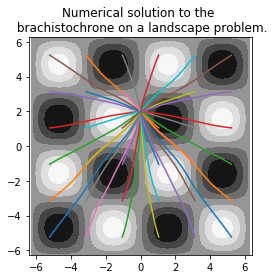

In [226]:
plt.figure(figsize=(4,4)); plt.axis('equal')
plt.title("Numerical solution to the \n brachistochrone on a landscape problem.") 
plt.contourf(*grid,Slide_Z(grid),cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(*geo)

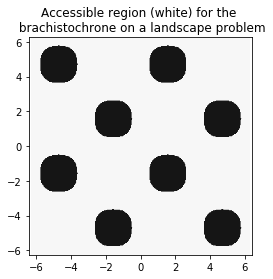

In [227]:
plt.figure(figsize=(4,4)); plt.axis('equal')
plt.title('Accessible region (white) for the \n brachistochrone on a landscape problem')
plt.contourf(*grid,Slide_Z(grid)<=0,cmap='Greys');

As usual, one can improve the accuracy of the fast marching method by using source factorization, a second order accurate scheme, and spreading the seed over a few pixels.

In [228]:
hfmIn2 = hfmIn.copy()
hfmIn2.update({
    # Improve accuracy
    'order':3,
    'factoringRadius':30,
    
    # Export relevant data
    'exportGeodesicFlow':True,
    'exportValues':True,
})

In [229]:
hfmOut = hfmIn2.RunSmart()

Field verbosity defaults to 1
Field seedRadius defaults to 2
Fast marching solver completed in 0.06883 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


### 2.2 Geodesic shooting

Let us introduce the analytic and interpolated Hamiltonians, as well as the energy of the paths and its gradient the  impulsion.

In [230]:
Slide_A = Metrics.Hamiltonian(Slide_A_,vdim=2,disassociate_ad=True)
Slide_I = Metrics.Hamiltonian(hfmIn['metric'],grid=grid)

Spline nterpolation in degree >1 requires that the array contains neither infinite nor nan values.

In [231]:
hfmOut['values'] [hfmIn['walls'] ] = 0. # Inserting dummy values in inaccessible places
energy_i,impulsion_i = energy_impulsion_i(hfmIn2,hfmOut,order=3)

In [232]:
q0 = hfmIn['tips'].copy().T
walls = Interp(grid,hfmIn['walls'],order=1)
q0 = q0[:,walls(q0)==0.]

p0 = -impulsion_i(q0)
T = np.linspace(0,1)

QP = scipy.integrate.odeint(Slide_A.flow_cat,np.concatenate((q0,p0),axis=0).flatten(),T)
nSamples=q0.shape[1]
Q = QP[:,:2*nSamples].reshape((len(T),2,nSamples))

Most geodesics obtained from geodesic shooting reach the initial seed, but not all. Long paths that come close to the inaccessibe regions raise most difficulties.

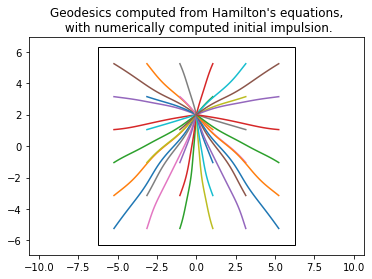

In [233]:
plt.title("Geodesics computed from Hamilton's equations,\n with numerically computed initial impulsion.")
plt.axis('equal'); add_patches(hfmIn)
for i in range(nSamples):
    plt.plot(*Q[:,:,i].T)

In [234]:
T = np.linspace(0,0.3)
QP = scipy.integrate.odeint(Slide_I.flow_cat,np.concatenate((q0,p0),axis=0).flatten(),T)
Q = QP[:,:2*nSamples].reshape((len(T),2,nSamples))

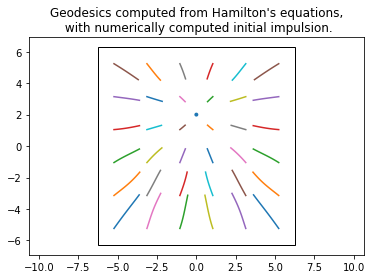

In [235]:
plt.title("Geodesics computed from Hamilton's equations,\n with numerically computed initial impulsion.")
plt.axis('equal'); add_patches(hfmIn)
for i in range(nSamples):
    plt.plot(*Q[:,:,i].T)